In [135]:
import random
import os
import torch
import torch.optim as optim
import torch.utils.data
import numpy as np
from pytorchtools import count_parameters
import torch.nn as nn
import pickle
from base_models import LSTMModel, FCN, ExtendedFCN
from torch.utils.data import Dataset, DataLoader
from metrics import torch_mae as mae
import argparse
from pytorchtools import EarlyStopping
from ts_dataset import TSDataset, SimpleDataset
from ts_transform import split_idx_50_50
from ts_dataset import DomainTSDataset, SimpleDataset


def set_bn_eval(module):
    if isinstance(module, torch.nn.modules.batchnorm._BatchNorm):
        module.eval()
        


def step(model, data_iter, len_dataloader, optimizer = None, loss = mae, is_train=False, threshold = False):

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    if is_train:
        model.train()
    else:
        #model.eval()
        model.eval()

    accum_err = 0
    accum_size = 0
    i = 0
    while i < len_dataloader:

        # training model using source data
        data_source = data_iter.next()
        x, y = data_source

        if is_train:
            model.zero_grad()
        
        x = torch.tensor(x).float().to(device)
        y = torch.tensor(y).float().to(device)

        y_pred = model(x) 

        if threshold:
            y_pred = torch.clamp(y_pred, 0, 1)

        err = loss(y, y_pred)

        if is_train:
            err.backward()
            optimizer.step()

        #print(err)
        accum_err +=err*x.shape[0]
        accum_size += x.shape[0]
        i += 1

    return float(accum_err/accum_size)
        


def train(model, train_loader, val_loader, early_stopping, learning_rate = 0.001, epochs = 500, add_weight_decay = False, monitor_stopping = True):

    optimizer = optim.SGD(model.parameters(), lr=learning_rate) if ~add_weight_decay else optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 10e-3)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience = early_stopping.patience//4, verbose=True)
    

    for epoch in range(epochs):

        len_train_loader = len(train_loader)
        train_iter = iter(train_loader)

        len_val_loader = len(val_loader)
        val_iter = iter(val_loader)

        mean_err = step(model, train_iter, len_train_loader, optimizer, is_train=True)

        with torch.no_grad():
            mean_err_val = step(model, val_iter, len_val_loader)

        print ('epoch: %d, \n TRAINING -> mean_err: %f' % (epoch, mean_err))
        print ('epoch: %d, \n VAL -> mean_err: %f' % (epoch, mean_err_val))

        scheduler.step(mean_err_val)

        if monitor_stopping:
            early_stopping(mean_err_val, model)

            if early_stopping.early_stop:
                print("Early stopping")
                break

        print('done')

    return epoch+1


def test(model, test_loader, output_directory, model_file, verbose = True, threshold = False):

    len_test_loader = len(test_loader)
    test_iter = iter(test_loader)

    model.load_state_dict(torch.load(model_file))

    with torch.no_grad():
        mean_err = step(model, test_iter, len_test_loader, threshold=True)

    print("Regression error on test: %f"%(mean_err))

    if verbose:
        f=open(output_directory+"/results.txt", "a+")
        f.write("Test error :%f"% mean_err)
        f.write("\n")
        f.close()

    return mean_err


def freeze_fcn(fcn):

    for params in fcn.named_parameters():
        if(params[0][:6]!="linear"):
            params[1].requires_grad=False
        elif (params[0]=="linear.weight"):
            l2_reg=torch.norm(params[1])
    
    return l2_reg

    





meta_info = {"POLLUTION": [5, 50, 14],
             "HR": [32, 50, 13],
             "BATTERY": [20, 50, 3] }

output_directory = "output/"
verbose=True
batch_size=64


params = {'batch_size': batch_size,
      'shuffle': True,
      'num_workers': 0}

dataset_name = "POLLUTION" 
mode = "WFT"
save_model_file = "temp_model.pt"
load_model_file = "model.pt"
lower_trial = 0
upper_trial = 1
learning_rate = 0.000001
regularization_penalty = 0.001
model_name = "FCN"
is_test = 1
patience_stopping = 20
epochs = 1

activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook



assert mode in ("WFT", "WOFT", "50"), "Mode was not correctly specified"
assert model_name in ("FCN", "LSTM"), "Model was not correctly specified"
assert dataset_name in ("POLLUTION", "HR", "BATTERY")

window_size, task_size, input_dim = meta_info[dataset_name]

train_data = pickle.load(  open( "../Data/TRAIN-"+dataset_name+"-W"+str(window_size)+"-T"+str(task_size)+"-NOML.pickle", "rb" ) )
validation_data = pickle.load( open( "../Data/VAL-"+dataset_name+"-W"+str(window_size)+"-T"+str(task_size)+"-NOML.pickle", "rb" ) )
validation_data_ML = pickle.load( open( "../Data/VAL-"+dataset_name+"-W"+str(window_size)+"-T"+str(task_size)+"-ML.pickle", "rb" ) )
test_data = pickle.load( open( "../Data/TEST-"+dataset_name+"-W"+str(window_size)+"-T"+str(task_size)+"-NOML.pickle", "rb" ) )
test_data_ML = pickle.load( open( "../Data/TEST-"+dataset_name+"-W"+str(window_size)+"-T"+str(task_size)+"-ML.pickle", "rb" ) )
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



for trial in range(lower_trial, upper_trial):

    output_directory = "../Models/"+dataset_name+"_"+model_name+"/"+str(trial)+"/"
    save_model_file_ = output_directory + save_model_file
    load_model_file_ = output_directory + load_model_file

    try:
        os.mkdir(output_directory)
    except OSError as error: 
        print(error)

    f=open(output_directory+"/results.txt", "a+")
    f.write("Dataset :%s"% dataset_name)
    f.write("\n")
    f.close()

    save_model_file_ = output_directory+save_model_file
    load_model_file_ = output_directory+load_model_file

    assert save_model_file!=load_model_file, "Files cannot be the same"

    n_tasks, task_size, dim, channels = test_data_ML.x.shape if is_test else validation_data_ML.x.shape
    horizon = 10
    #epochs = 20
    test_loss_list = []
    initial_test_loss_list = []
    train_mean_list = []
    test_mean_list = []

    for task_id in range(0, (n_tasks-horizon-1), n_tasks//100):


        #check that all files blong to the same domain
        temp_file_idx = test_data_ML.file_idx[task_id:task_id+horizon+1]
        if(len(np.unique(temp_file_idx))>1):
            continue

        if is_test: 
            temp_x_train = test_data_ML.x[task_id][:int(task_size*0.8)]
            temp_y_train = test_data_ML.y[task_id][:int(task_size*0.8)]

            temp_x_val = test_data_ML.x[task_id][int(task_size*0.8):]
            temp_y_val = test_data_ML.y[task_id][int(task_size*0.8):]

            temp_x_test = test_data_ML.x[(task_id+1):(task_id+horizon+1)].reshape(-1, dim, channels)
            temp_y_test = test_data_ML.y[(task_id+1):(task_id+horizon+1)].reshape(-1, 1)

        else:
            temp_x_train = validation_data_ML.x[task_id][:int(task_size*0.8)]
            temp_y_train = validation_data_ML.y[task_id][:int(task_size*0.8)]

            temp_x_val = validation_data_ML.x[task_id][int(task_size*0.8):]
            temp_y_val = validation_data_ML.y[task_id][int(task_size*0.8):]

            temp_x_test = validation_data_ML.x[(task_id+1):(task_id+horizon+1)].reshape(-1, dim, channels)
            temp_y_test = validation_data_ML.y[(task_id+1):(task_id+horizon+1)].reshape(-1, 1)               

        if model_name == "FCN":

            kernels = [8,5,3] if dataset_name!= "POLLUTION" else [4,2,1]
            temp_x_train = np.transpose(temp_x_train, [0,2,1])
            temp_x_test = np.transpose(temp_x_test, [0,2,1])
            temp_x_val = np.transpose(temp_x_val, [0,2,1])

        early_stopping = EarlyStopping(patience=patience_stopping, model_file=save_model_file_, verbose=verbose)


        if model_name == "LSTM":
            model = LSTMModel( batch_size=batch_size, seq_len = window_size, input_dim = input_dim, n_layers = 2, hidden_dim = 120, output_dim =1)
        elif model_name == "FCN":
            model = FCN(time_steps = window_size, channels=[input_dim, 128, 128, 128], kernels=kernels )


        model.load_state_dict(torch.load(load_model_file_))

        for name, layer in model.named_modules():
            layer.register_forward_hook(get_activation(name))

        train_loader = DataLoader(SimpleDataset(x=temp_x_train, y=temp_y_train), **params)
        val_loader = DataLoader(SimpleDataset(x=temp_x_val, y=temp_y_val), **params)
        test_loader = DataLoader(SimpleDataset(x=temp_x_test, y=temp_y_test), **params)

        model.cuda()
        initial_loss = test(model, test_loader, output_directory, load_model_file_, True)

        if model_name == "FCN":
            #pass
            freeze_fcn(model)
            model.apply(set_bn_eval)
            #model = ExtendedFCN(model, 20,1)
            #model.cuda()

        early_stopping(initial_loss, model)
        train(model, train_loader, val_loader, early_stopping, learning_rate, epochs, add_weight_decay=True)
        print("Max train:" , torch.max(activation["conv3.batch_norm"]))
        print("Mean train:" , torch.mean(activation["conv3.batch_norm"]))
        train_mean_list.append(torch.max(activation["conv3.batch_norm"]))
      
        loss = test(model, test_loader, output_directory, save_model_file_, False)
        print("Max test:",  torch.max(activation["conv3.batch_norm"]))
        print("Mean test:" , torch.mean(activation["conv3.batch_norm"]))
        test_mean_list.append(torch.max(activation["conv3.batch_norm"]))
        print(loss)

        test_loss_list.append(loss)
        initial_test_loss_list.append(initial_loss)





[WinError 183] Cannot create a file when that file already exists: '../Models/POLLUTION_FCN/0/'
Regression error on test: 0.042617
Validation loss decreased (inf --> 0.042617).  Saving model ...
epoch: 0, 
 TRAINING -> mean_err: 0.066392
epoch: 0, 
 VAL -> mean_err: 0.018706
Validation loss decreased (0.042617 --> 0.018706).  Saving model ...
done
Max train: tensor(0.7674, device='cuda:0')
Mean train: tensor(-0.0926, device='cuda:0')
Regression error on test: 0.050347
Max test: tensor(9.1895, device='cuda:0')
Mean test: tensor(-0.3851, device='cuda:0')
0.05034725368022919
Regression error on test: 0.035745
Validation loss decreased (inf --> 0.035745).  Saving model ...
epoch: 0, 
 TRAINING -> mean_err: 0.040679
epoch: 0, 
 VAL -> mean_err: 0.066025
EarlyStopping counter: 1 out of 20
done
Max train: tensor(1.8083, device='cuda:0')
Mean train: tensor(-0.2953, device='cuda:0')
Regression error on test: 0.035745

C:\Users\Sebastian\Anaconda3\envs\pytorch12\lib\site-packages\ipykernel_launcher.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\Sebastian\Anaconda3\envs\pytorch12\lib\site-packages\ipykernel_launcher.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Max test: tensor(0.6872, device='cuda:0')
Mean test: tensor(-0.1251, device='cuda:0')
0.03574452921748161
Regression error on test: 0.024636
Validation loss decreased (inf --> 0.024636).  Saving model ...
epoch: 0, 
 TRAINING -> mean_err: 0.056882
epoch: 0, 
 VAL -> mean_err: 0.041688
EarlyStopping counter: 1 out of 20
done
Max train: tensor(1.6262, device='cuda:0')
Mean train: tensor(-0.1988, device='cuda:0')
Regression error on test: 0.024636
Max test: tensor(0.6297, device='cuda:0')
Mean test: tensor(-0.1396, device='cuda:0')
0.024635571986436844
Regression error on test: 0.022922
Validation loss decreased (inf --> 0.022922).  Saving model ...
epoch: 0, 
 TRAINING -> mean_err: 0.053805
epoch: 0, 
 VAL -> mean_err: 0.081634
EarlyStopping counter: 1 out of 20
done
Max train: tensor(3.3269, device='cuda:0')
Mean train: tensor(0.0557, device='cuda:0')
Regression error on test: 0.022922
Max test: tensor(0.4992, device='cuda:0')
Mean test: tensor(-0.1234, device='cuda:0')
0.0229217316955

Regression error on test: 0.059158
Validation loss decreased (inf --> 0.059158).  Saving model ...
epoch: 0, 
 TRAINING -> mean_err: 0.060319
epoch: 0, 
 VAL -> mean_err: 0.089605
EarlyStopping counter: 1 out of 20
done
Max train: tensor(0.8915, device='cuda:0')
Mean train: tensor(-0.1224, device='cuda:0')
Regression error on test: 0.059158
Max test: tensor(2.0804, device='cuda:0')
Mean test: tensor(-0.1429, device='cuda:0')
0.05915763974189758
Regression error on test: 0.068782
Validation loss decreased (inf --> 0.068782).  Saving model ...
epoch: 0, 
 TRAINING -> mean_err: 0.030808
epoch: 0, 
 VAL -> mean_err: 0.035613
Validation loss decreased (0.068782 --> 0.035613).  Saving model ...
done
Max train: tensor(1.5176, device='cuda:0')
Mean train: tensor(-0.0134, device='cuda:0')
Regression error on test: 0.084462
Max test: tensor(2.8263, device='cuda:0')
Mean test: tensor(-0.2053, device='cuda:0')
0.08446158468723297
Regression error on test: 0.083173
Validation loss decreased (inf --

Regression error on test: 0.025766
Max test: tensor(1.3397, device='cuda:0')
Mean test: tensor(-0.1937, device='cuda:0')
0.025766411796212196
Regression error on test: 0.026533
Validation loss decreased (inf --> 0.026533).  Saving model ...
epoch: 0, 
 TRAINING -> mean_err: 0.040026
epoch: 0, 
 VAL -> mean_err: 0.039705
EarlyStopping counter: 1 out of 20
done
Max train: tensor(6.7601, device='cuda:0')
Mean train: tensor(-1.4648, device='cuda:0')
Regression error on test: 0.026533
Max test: tensor(1.5713, device='cuda:0')
Mean test: tensor(-0.1447, device='cuda:0')
0.026532797142863274
Regression error on test: 0.026848
Validation loss decreased (inf --> 0.026848).  Saving model ...
epoch: 0, 
 TRAINING -> mean_err: 0.057501
epoch: 0, 
 VAL -> mean_err: 0.075537
EarlyStopping counter: 1 out of 20
done
Max train: tensor(2.2853, device='cuda:0')
Mean train: tensor(-0.0569, device='cuda:0')
Regression error on test: 0.026848
Max test: tensor(0.4359, device='cuda:0')
Mean test: tensor(-0.13

Regression error on test: 0.157168
Max test: tensor(33.7825, device='cuda:0')
Mean test: tensor(-2.6914, device='cuda:0')
0.15716801583766937
Regression error on test: 0.049224
Validation loss decreased (inf --> 0.049224).  Saving model ...
epoch: 0, 
 TRAINING -> mean_err: 0.114062
epoch: 0, 
 VAL -> mean_err: 0.113192
EarlyStopping counter: 1 out of 20
done
Max train: tensor(1.2018, device='cuda:0')
Mean train: tensor(-0.1168, device='cuda:0')
Regression error on test: 0.049224
Max test: tensor(1.8899, device='cuda:0')
Mean test: tensor(-0.1895, device='cuda:0')
0.04922439530491829
Regression error on test: 0.068878
Validation loss decreased (inf --> 0.068878).  Saving model ...
epoch: 0, 
 TRAINING -> mean_err: 0.044727
epoch: 0, 
 VAL -> mean_err: 0.054455
Validation loss decreased (0.068878 --> 0.054455).  Saving model ...
done
Max train: tensor(1.7039, device='cuda:0')
Mean train: tensor(-0.1837, device='cuda:0')
Regression error on test: 0.103629
Max test: tensor(11.0632, device

Mean test: tensor(-0.1164, device='cuda:0')
0.02618332765996456
Regression error on test: 0.028543
Validation loss decreased (inf --> 0.028543).  Saving model ...
epoch: 0, 
 TRAINING -> mean_err: 0.030743
epoch: 0, 
 VAL -> mean_err: 0.060578
EarlyStopping counter: 1 out of 20
done
Max train: tensor(2.1676, device='cuda:0')
Mean train: tensor(0.0139, device='cuda:0')
Regression error on test: 0.028543
Max test: tensor(1.3390, device='cuda:0')
Mean test: tensor(-0.1751, device='cuda:0')
0.02854268066585064
Regression error on test: 0.026828
Validation loss decreased (inf --> 0.026828).  Saving model ...
epoch: 0, 
 TRAINING -> mean_err: 0.050143
epoch: 0, 
 VAL -> mean_err: 0.027465
EarlyStopping counter: 1 out of 20
done
Max train: tensor(5.6084, device='cuda:0')
Mean train: tensor(-1.0515, device='cuda:0')
Regression error on test: 0.026828
Max test: tensor(1.3499, device='cuda:0')
Mean test: tensor(-0.2106, device='cuda:0')
0.02682769112288952
Regression error on test: 0.022092
Vali

Regression error on test: 0.052244
Validation loss decreased (inf --> 0.052244).  Saving model ...
epoch: 0, 
 TRAINING -> mean_err: 0.212171
epoch: 0, 
 VAL -> mean_err: 0.061148
EarlyStopping counter: 1 out of 20
done
Max train: tensor(2.1331, device='cuda:0')
Mean train: tensor(-0.1640, device='cuda:0')
Regression error on test: 0.052244
Max test: tensor(2.4326, device='cuda:0')
Mean test: tensor(-0.1833, device='cuda:0')
0.052243683487176895
Regression error on test: 0.050820
Validation loss decreased (inf --> 0.050820).  Saving model ...
epoch: 0, 
 TRAINING -> mean_err: 0.059977
epoch: 0, 
 VAL -> mean_err: 0.040124
Validation loss decreased (0.050820 --> 0.040124).  Saving model ...
done
Max train: tensor(3.9838, device='cuda:0')
Mean train: tensor(-0.8478, device='cuda:0')
Regression error on test: 0.095046
Max test: tensor(13.5754, device='cuda:0')
Mean test: tensor(-0.4252, device='cuda:0')
0.09504624456167221
Regression error on test: 0.058607
Validation loss decreased (inf 

In [136]:
np.mean(test_loss_list)

0.05310412021163775

In [137]:
np.mean(initial_test_loss_list)

0.04361950606107712

In [113]:
test_mean_list = [float(value.cpu().numpy()) for value in test_mean_list]
test_mean_list

[8.858769416809082,
 0.6871629953384399,
 0.6871629953384399,
 0.5269408822059631,
 0.4071384072303772,
 0.4653656482696533,
 0.6015992760658264,
 0.6015992760658264,
 0.40011513233184814,
 14.171381950378418,
 12.543201446533203,
 0.6434835195541382,
 28.845848083496094,
 18.203317642211914,
 43.29744338989258,
 5.762270450592041,
 1.3677839040756226,
 0.9711898565292358,
 1.399558186531067,
 61.61814880371094,
 37.43205261230469,
 2.856884717941284,
 2.1980061531066895,
 10.318024635314941,
 2.481008768081665,
 1.8975188732147217,
 51.82759094238281,
 1.126019835472107,
 11.637490272521973,
 7.908130168914795,
 1.3847213983535767,
 11.427200317382812,
 1.1226650476455688,
 0.9623705148696899,
 1.125654697418213,
 8.254537582397461,
 63.58479309082031,
 0.7109610438346863,
 1.3608527183532715,
 1.5712834596633911,
 0.4483189582824707,
 0.45068833231925964,
 20.549781799316406,
 0.42190927267074585,
 0.42126578092575073,
 21.160276412963867,
 0.4225389361381531,
 0.4379439055919647,
 1

In [66]:
test_mean_list = [float(value) for value in test_mean_list]


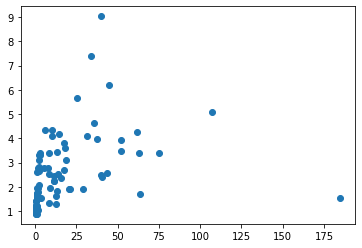

In [114]:
plt.scatter(test_mean_list, np.array(test_loss_list)*40)

In [115]:
np.corrcoef( np.array(test_loss_list), np.array(test_mean_list))

array([[1.        , 0.40497154],
       [0.40497154, 1.        ]])

In [102]:
help(np.correlate)

Help on function correlate in module numpy:

correlate(a, v, mode='valid')
    Cross-correlation of two 1-dimensional sequences.
    
    This function computes the correlation as generally defined in signal
    processing texts::
    
        c_{av}[k] = sum_n a[n+k] * conj(v[n])
    
    with a and v sequences being zero-padded where necessary and conj being
    the conjugate.
    
    Parameters
    ----------
    a, v : array_like
        Input sequences.
    mode : {'valid', 'same', 'full'}, optional
        Refer to the `convolve` docstring.  Note that the default
        is 'valid', unlike `convolve`, which uses 'full'.
    old_behavior : bool
        `old_behavior` was removed in NumPy 1.10. If you need the old
        behavior, use `multiarray.correlate`.
    
    Returns
    -------
    out : ndarray
        Discrete cross-correlation of `a` and `v`.
    
    See Also
    --------
    convolve : Discrete, linear convolution of two one-dimensional sequences.
    multiarray.cor

In [121]:
import matplotlib.pyplot as plt
import pandas as pd
np.array([np.array(test_mean_list), np.array(test_loss_list)]).T

array([[8.85876942e+00, 4.87865694e-02],
       [6.87162995e-01, 3.57445292e-02],
       [6.87162995e-01, 2.46355738e-02],
       [5.26940882e-01, 2.29217317e-02],
       [4.07138407e-01, 2.35769991e-02],
       [4.65365648e-01, 2.37965062e-02],
       [6.01599276e-01, 2.51887832e-02],
       [6.01599276e-01, 2.81453393e-02],
       [4.00115132e-01, 2.74146665e-02],
       [1.41713820e+01, 1.04562968e-01],
       [1.25432014e+01, 4.03604060e-02],
       [6.43483520e-01, 2.28510294e-02],
       [2.88458481e+01, 4.77253273e-02],
       [1.82033176e+01, 8.96150172e-02],
       [4.32974434e+01, 6.45654052e-02],
       [5.76227045e+00, 1.08684771e-01],
       [1.36778390e+00, 6.57050684e-02],
       [9.71189857e-01, 4.41123396e-02],
       [1.39955819e+00, 4.23325486e-02],
       [6.16181488e+01, 1.06336646e-01],
       [3.74320526e+01, 9.89117250e-02],
       [2.85688472e+00, 8.24431777e-02],
       [2.19800615e+00, 8.31728801e-02],
       [1.03180246e+01, 1.02133252e-01],
       [2.481008

In [122]:
train_mean_list = [float(value.cpu().numpy()) for value in train_mean_list]


In [123]:
np.array([train_mean_list]).T

array([[ 0.69476694],
       [ 4.08794785],
       [ 3.46697855],
       [ 3.67487478],
       [ 1.53541088],
       [ 0.74450016],
       [ 0.87775272],
       [ 7.28045797],
       [ 0.896106  ],
       [ 2.32488894],
       [ 3.46690083],
       [ 5.87622738],
       [ 2.4660449 ],
       [ 2.65226793],
       [24.8105526 ],
       [ 0.82698828],
       [ 3.58082652],
       [ 4.236485  ],
       [ 1.5969944 ],
       [ 3.23333931],
       [ 1.32442319],
       [ 1.4947139 ],
       [ 7.37392473],
       [ 0.6975252 ],
       [ 2.1145699 ],
       [ 1.6653769 ],
       [ 7.32581568],
       [ 1.71675408],
       [ 5.62009859],
       [ 1.50227487],
       [ 0.84008986],
       [ 1.09163427],
       [ 2.44197893],
       [ 6.41746712],
       [ 1.34061682],
       [ 1.31571043],
       [14.97131348],
       [ 1.30785549],
       [ 2.11955261],
       [11.42291451],
       [ 8.081007  ],
       [ 3.56057978],
       [ 1.42133546],
       [ 2.17818594],
       [ 1.83935237],
       [ 1

In [14]:
for name, parameter in model.named_parameters():
    print(parameter.requires_grad)
    print(name)

False
conv1.conv.weight
False
conv1.conv.bias
False
conv1.batch_norm.weight
False
conv1.batch_norm.bias
False
conv2.conv.weight
False
conv2.conv.bias
False
conv2.batch_norm.weight
False
conv2.batch_norm.bias
False
conv3.conv.weight
False
conv3.conv.bias
False
conv3.batch_norm.weight
False
conv3.batch_norm.bias
True
linear.weight
True
linear.bias


In [18]:
from pytorchtools import to_torch
model.conv3.batch_norm(to_torch(temp_x_train))

RuntimeError: running_mean should contain 14 elements not 128

In [27]:
print("Max train:" , torch.max(activation["conv3.batch_norm"]))

In [43]:
from torch.autograd import Variable
model.conv3.register_backward_hook(get_activation('conv3'))
y = model(Variable(to_torch(temp_x_train)))

In [45]:
activation["conv3"]

KeyError: 'conv3'

In [57]:
activation


{}

In [55]:
y = model(Variable(to_torch(temp_x_train)))


tensor(3.2374, device='cuda:0')